In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from aeon.transformations.collection.dictionary_based import PAA
import seaborn as sns
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import euclidean
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matrixprofile import *
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from matrixprofile.discords import discords
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import itertools

In [2]:
def load_npy(filename):
    return np.load(filename)

In [3]:
dir_path = 'C:/Users/marco/OneDrive/Desktop/Unipi/Primo anno/Secondo semestre/Data Mining 2/Lab/dm2_lab00_spotify/time_series/'
len_threshold = 1280

In [ ]:
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    track_id = split[0]
    genre = split[1][:-4]  # Remove '.npy' extension
    ts = load_npy(os.path.join(dir_path, file))  # Load time series data
    
    # Check if the length of ts is strictly greater than len_threshold
    if len(ts) > len_threshold:
        print(f"Time series {file} is longer than len_threshold and will be cut.")
        ts = ts[:len_threshold]  # Trim ts to len_threshold
    elif len(ts) == len_threshold:
        pass  # Time series is exactly len_threshold, no need to print anything
    elif len_threshold - len(ts) < 20:
        pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        ts = np.append(ts, pad) 
        print(f"Time series {file} is a bit shorter than len_threshold, it was padded to len_threshold.")
    else: 
        print(f"Time series {file} is much shorter than len_threshold and will be skipped.")
        continue  # Skip this iteration if ts is shorter than len_threshold
    
    # Append data to X, y, and ids
    X.append(ts)
    y.append(genre)
    ids.append(track_id)

# Convert lists to numpy arrays
X, y, ids = np.array(X), np.array(y), np.array(ids)

#0DVMaexfdXDz19zUv1zKej_kids.npy was (830,)
#0P2DLw3xEcOgyYI7Ye4whM_honky-tonk.npy was (1263,)

In [3]:
# these (or any other) numpy arrays can be also saved as npy files (for subsequent reloading)
#np.savez('X_y_ids', X, y, ids)

# reload
X_y_ids = load_npy('X_y_ids.npz') 
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']

## Approximation

In [4]:
def approximate(ts, approx):
    return approx.fit_transform(ts)
    
paa = PAA(n_segments=256)
X_paa = approximate(X, paa)
X_paa.shape

(9999, 1, 256)

In [5]:
X.shape

(9999, 1, 1280)

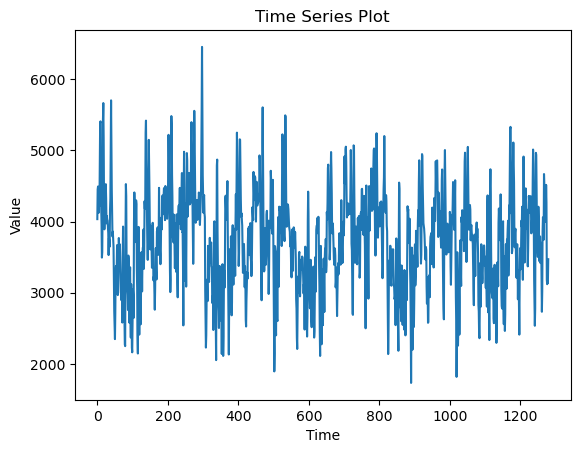

In [6]:
plt.plot(X[0][0])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.show()

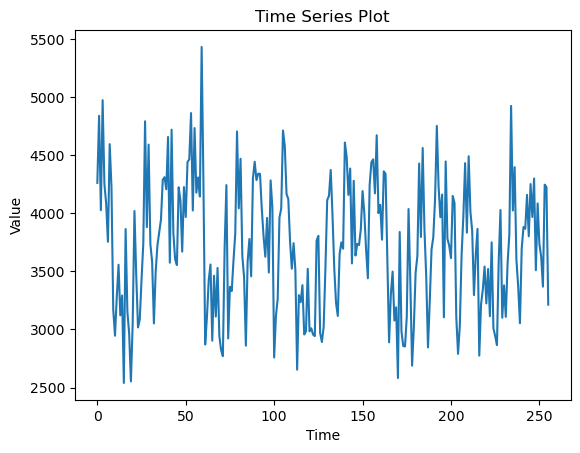

In [7]:
plt.plot(X_paa[0][0])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.show()

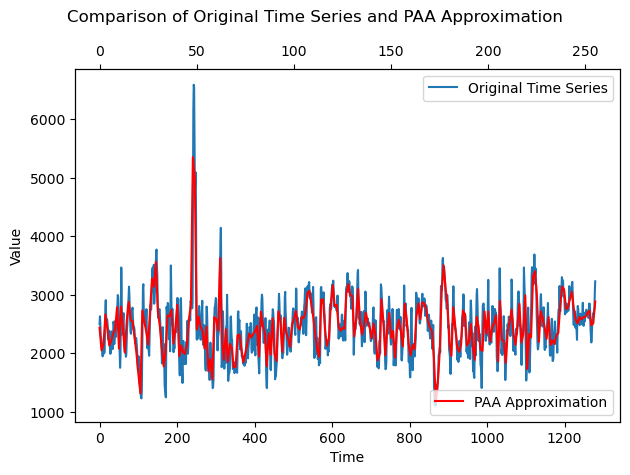

In [37]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot the original time series
ax1.plot(X[100][0], label="Original Time Series")

# Set labels and legend for the original time series
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.legend()

# Create a second y-axis for the PAA approximated time series
ax2 = ax1.twiny()

# Plot the PAA approximated time series
ax2.plot(X_paa[100][0], "r-", label="PAA Approximation")

# Set labels and legend for the PAA approximated time series
ax2.set_ylabel('PAA Value')
ax2.legend(loc='lower right')

# Add a title to the graph
plt.suptitle('Comparison of Original Time Series and PAA Approximation')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Importing normalized distance Matrix
df_normalized_dm = pd.read_csv(r'C:\Users\marco\OneDrive\Desktop\Unipi\Primo anno\Secondo semestre\Data Mining 2\Lab\dtw_distance_matrix_standard.csv')

## Matrix Profile and Motifs discovery
***

In [36]:
list_mp = []
list_mpi = []
list_mo = []
list_mod = []

w = 8
for i in tqdm(range(len(X_paa)), desc="Processing Time Series"):  # tqdm wraps around the range function
    # Defining Matrix profile and Matrix profile index
    mp, mpi = matrixProfile.stomp(X_paa[i][0], w)
    list_mp.append(mp)
    list_mpi.append(mpi)
    # Defining motifs and mod
    mo, mod = motifs.motifs(X_paa[i][0], (mp, mpi), max_motifs=1, n_neighbors=1)
    list_mo.append(mo)
    list_mod.append(mod)

Processing Time Series:  53%|█████▎    | 5342/9999 [02:11<02:11, 35.30it/s]C:\Users\marco\anaconda\Lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: divide by zero encountered in divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\marco\anaconda\Lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: invalid value encountered in divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\marco\anaconda\Lib\site-packages\matrixprofile\distanceProfile.py:118: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))
C:\Users\marco\anaconda\Lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: divide by zero encountered in divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\marco\anaconda\Lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: invalid value encountered in divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\marco\

In [21]:
# Making the list of motifs indexes flat
list_mo2 =np.squeeze(list_mo)
flat_list_mo2 = list_mo2.flatten()

In [22]:
def create_df(indexes_list, X_paa):
    num_cols = 8  # Number of columns per row (8 + 1)

    # Create an empty DataFrame with the desired columns
    columns = [f'Value_{i}' for i in range(num_cols)]
    df = pd.DataFrame(columns=columns)

    # Calculate the total number of iterations (assuming 9999 as maximum)
    total_iterations = len(indexes_list)

    iter_counts = 0 
    j = 0 
    # Use tqdm to create a progress bar
    for index in tqdm(indexes_list[:total_iterations], desc="Processing time series", unit="series"):
       # Two iterations per row in X_paa
        # Calculate the end index for the slice
        end_index = index + num_cols
        
        # Slice X_paa to get the desired columns for the current index
        subset = X_paa[j, 0, index:end_index]
        iter_counts += 1
        if iter_counts %2 == 0:
            j+=1
        
        # Convert the subset to a list to create a DataFrame
        subset_list = subset.tolist()
        
        # Append the subset to the DataFrame
        df = pd.concat([df, pd.DataFrame([subset_list], columns=columns)], ignore_index=True)

    return df

In [23]:
df = create_df(flat_list_mo2, X_paa)  # Adjusted to iterate over first 10 elements for demonstration
df

Processing time series: 100%|██████████| 19998/19998 [00:19<00:00, 1040.39series/s]


Value_0      Value_1      Value_2      Value_3      Value_4  \
0      3330.628139  3591.831405  3824.360275  4703.741333  4042.502722   
1      3108.408469  3564.456405  3818.724185  4923.835961  4023.738366   
2      1374.245727   981.082764  1589.556876  2096.229308  3864.190243   
3      1187.049683  1180.161030  1367.761739  1607.097250  2625.276635   
4       846.759111   793.374345   662.467039   709.648411   666.693671   
...            ...          ...          ...          ...          ...   
19993  1741.893516  1652.816434  1665.860487  1959.931712  2045.260391   
19994   338.836809   348.411058   355.747382   333.554363   335.083558   
19995   426.684863   437.295342   441.836380   410.695812   410.558784   
19996   357.817633   328.008087   334.711529   331.185139   346.151814   
19997   318.131479   287.769847   295.498120   292.404027   305.642196   

           Value_5      Value_6      Value_7  
0      4469.503605  3633.610262  3449.478241  
1      4396.572363  3600.821816  3372.278668  
2      3131.357704  2545.148865  1947.575978  
3      2353.945169  1655.561121  1646.695781  
4       564.431016   562.156827   582.740456  
...            ...          ...          ...  
19993  2201.051170  2766.449887  2767.813561  
19994   331.875721   307.221525   315.604023  
19995   407.459850   358.636833   366.121711  
19996   384.404987   363.854251   358.543735  
19997   336.607542   316.854420   322.351293  

[19998 rows x 8 columns]

In [48]:
m = 8
pattern = X_paa[0][0]
def plot_motifs(mtfs, labels, ax):

    colori = 0
    colors = 'rgbcm'
    for ms,l in zip(mtfs,labels):
        c =colors[colori % len(colors)]
        starts = list(ms)
        ends = [min(s + m,len(pattern)-1) for s in starts]
        ax.plot(starts, pattern[starts],  c +'o',  label=l)
        ax.plot(ends, pattern[ends],  c +'o', markerfacecolor='none')
        for nn in ms:
            ax.plot(range(nn,nn+m),pattern[nn:nn+m], c , linewidth=2)
        colori += 1

    ax.plot(pattern, 'k', linewidth=1, label="data")
    ax.legend()

In [68]:
print(mo)
print(list_mod[0])

[[78, 129]]
[0.40230275438552376]


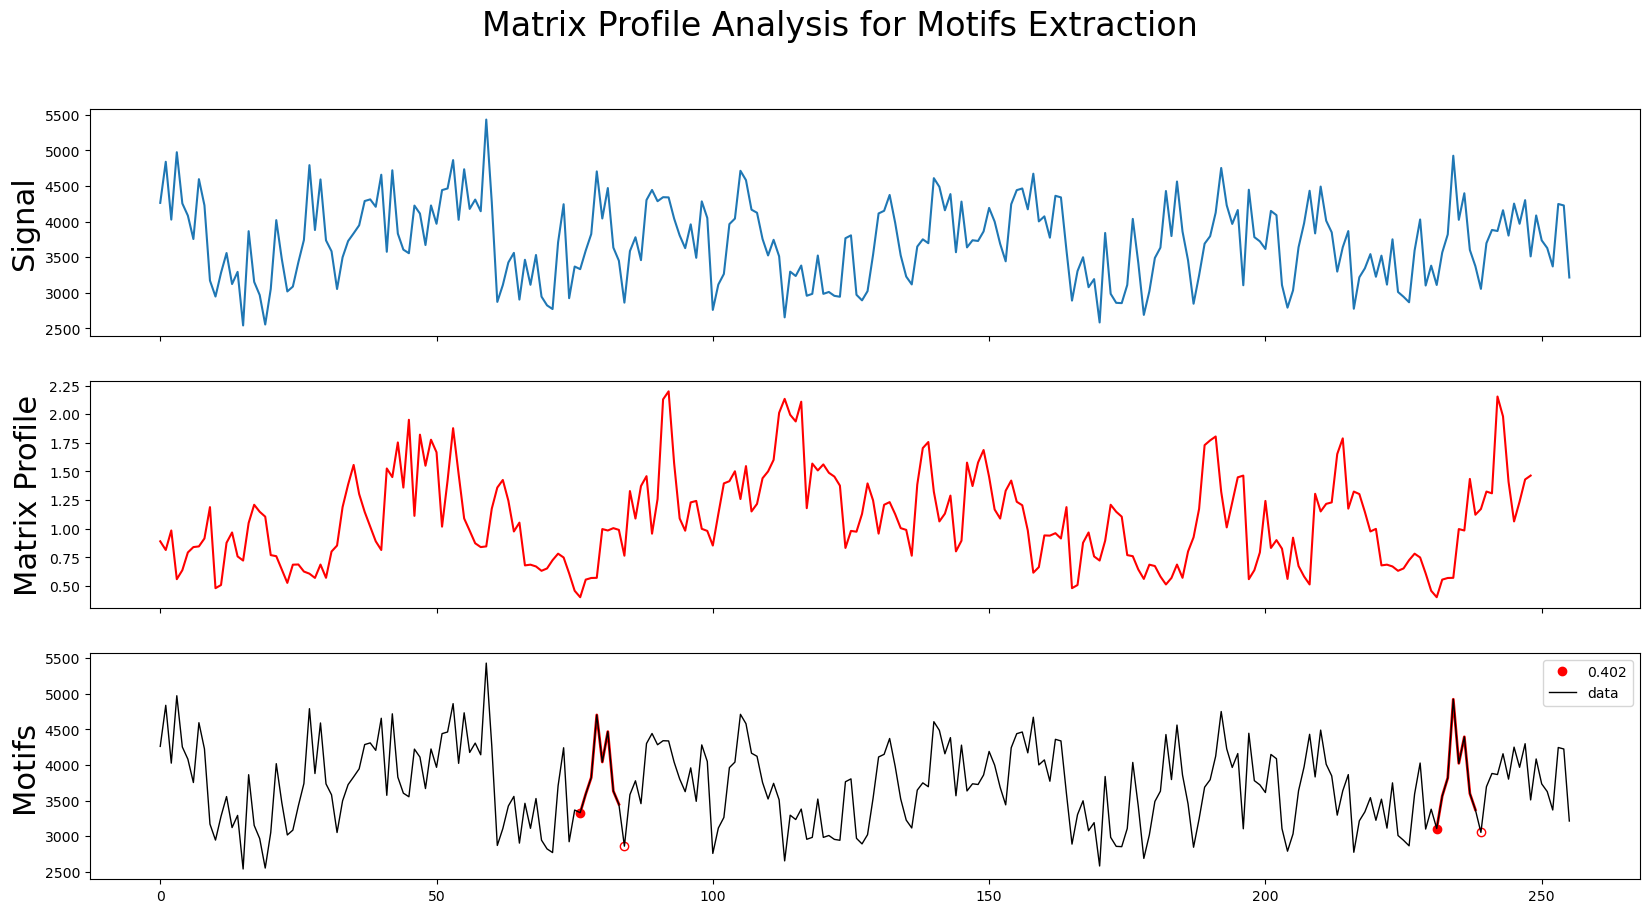

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Append np.nan to Matrix profile to enable plotting against raw data
mp_adj = np.append(list_mp[0], np.zeros(8-1) + np.nan)

# Plot the signal data
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(20, 10))
ax1.plot(np.arange(len(X_paa[0][0])), X_paa[0][0], label="Synthetic Data")
ax1.set_ylabel('Signal', size=22)


# Plot the Matrix Profile
ax2.plot(np.arange(len(mp_adj)), mp_adj, label="Matrix Profile", color='red')
ax2.set_ylabel('Matrix Profile', size=22)


# Plot the Motifs
plot_motifs(list_mo[0], [f"{md:.3f}" for md in list_mod[0]], ax3)
ax3.set_ylabel('Motifs', size=22)


# Add a title to the graph
plt.suptitle('Matrix Profile Analysis for Motifs Extraction', fontsize=24)

plt.show()


In [224]:
# Random Sample dataset:
# Assuming df is your original dataset

# Sample 20 rows randomly from the dataset
random_sample = df.sample(n=20, random_state=42)

# Create a new dataset with the randomly selected rows
new_dataset = pd.DataFrame(random_sample)

# Optionally, reset the index of the new dataset
new_dataset.reset_index(drop=True, inplace=True)

In [242]:
#new_dataset= new_dataset.drop('cluster', axis = 1)
new_dataset_val = new_dataset.values

In [262]:
StandardScaler = StandardScaler()
# Fit and transform the data
new_dataset_val = StandardScaler.fit_transform(new_dataset_val)

In [333]:
X_train_scaled = StandardScaler.fit_transform(np.squeeze(X_paa[X_train_original_indices]))

In [341]:
X_test_scaled = StandardScaler.fit_transform(np.squeeze(X_paa[X_test_original_indices]))

In [335]:
X_train_scaled.shape

(9000, 256)

In [338]:
from scipy.spatial.distance import euclidean

# Assuming dataset is your 2D array of shape (9000, 256) containing the time series dataset
# Assuming motifs is your 3D array of shape (20, 8, 8) containing the motifs

# Initialize an empty DataFrame to store the minimum distances
min_distances_df_train = pd.DataFrame(index=range(9000), columns=range(20))

# Iterate over each motif
for motif_idx, motif in enumerate(new_dataset_val):
    # Initialize an array to store the minimum distances for the current motif
    min_distances = np.zeros(9000)
    
    # Iterate over each row of the dataset
    for row_idx, row in enumerate(X_train_scaled):
        # Initialize the minimum distance for the current row
        min_distance = float('inf')
        
        # Iterate over each subsequence of the current row
        for start_idx in range(len(row) - len(motif) + 1):
            # Calculate the Euclidean distance between the motif and the current subsequence
            distance = euclidean(motif, row[start_idx:start_idx+len(motif)])
            
            # Update the minimum distance if the current distance is lower
            if distance < min_distance:
                min_distance = distance
        
        # Store the minimum distance for the current row
        min_distances[row_idx] = min_distance
    
    # Store the minimum distances for the current motif in the DataFrame
    min_distances_df_train[motif_idx] = min_distances

# Display the resulting DataFrame
min_distances_df_train

0         1         2         3         4         5         6   \
0     0.639328  2.897254  2.619687  1.459558  3.126531  5.157405  2.391892   
1     0.790028  4.010857  3.270420  1.597892  3.417481  5.716188  2.747414   
2     1.818845  6.900709  4.721307  4.455585  6.405473  8.719572  5.729392   
3     2.031087  1.079202  2.691538  0.737278  0.571936  2.638669  0.584303   
4     0.387857  1.778164  2.756204  0.507113  0.548356  1.440109  0.593685   
...        ...       ...       ...       ...       ...       ...       ...   
8995  0.548000  1.628061  2.243491  0.766097  0.986406  3.007668  0.888005   
8996  0.837601  2.083824  2.491782  0.755874  1.578355  3.671104  0.740856   
8997  3.346565  1.158229  2.726501  1.116592  1.059079  1.664852  0.956549   
8998  0.343783  3.927569  3.094915  1.415781  3.404623  5.678591  2.732868   
8999  3.332366  0.927854  2.697341  0.940076  0.582294  1.084534  0.741416   

            7         8         9         10        11        12        13  \
0     1.014976  2.559372  0.842704  2.486122  0.802481  2.831364  2.194122   
1     0.686096  3.255139  2.966127  3.657710  0.548883  3.182888  2.756490   
2     2.497195  6.225955  0.347593  5.484046  2.386762  6.134686  5.610484   
3     1.522888  0.725643  4.309956  2.573273  1.550603  0.657594  0.668851   
4     0.421600  0.818065  1.651544  2.918538  0.164663  1.288489  1.177771   
...        ...       ...       ...       ...       ...       ...       ...   
8995  0.619372  1.155742  2.644910  2.601125  0.559292  0.848205  1.184389   
8996  0.608342  1.100347  2.153934  2.689539  0.687968  1.392148  0.740098   
8997  2.699535  1.058587  5.618967  2.809589  3.019718  0.763683  0.484025   
8998  0.567218  3.209752  0.770905  3.389909  0.424993  3.146398  2.630596   
8999  2.645521  0.689745  5.515925  2.549830  2.831027  0.858757  0.668362   

            14        15        16        17        18        19  
0     2.782664  1.381467  2.769165  1.194072  0.524996  0.964427  
1     3.582139  1.355155  3.430757  1.348973  1.381877  3.029012  
2     6.442084  3.741298  6.298667  4.195102  1.187403  0.269636  
3     0.587304  1.120612  0.818495  0.813157  2.715575  4.363330  
4     1.505259  0.855988  1.046386  0.418037  0.377702  1.677403  
...        ...       ...       ...       ...       ...       ...  
8995  1.391964  0.821972  1.227881  0.616282  1.201883  2.691304  
8996  1.686953  1.005848  1.654404  0.637351  1.020048  2.204964  
8997  1.117244  1.866564  1.256319  1.451627  4.099260  5.639268  
8998  3.509139  1.080924  3.326383  1.181756  0.230641  0.775769  
8999  0.860809  1.454494  0.953697  1.064177  3.991207  5.541594  

[9000 rows x 20 columns]

In [355]:
# Assuming dataset is your 2D array of shape (9000, 256) containing the time series dataset
# Assuming motifs is your 3D array of shape (20, 8, 8) containing the motifs

# Initialize an empty DataFrame to store the minimum distances
min_distances_df_test = pd.DataFrame(index=range(999), columns=range(20))

# Iterate over each motif
for motif_idx, motif in enumerate(new_dataset_val):
    # Initialize an array to store the minimum distances for the current motif
    min_distances = np.zeros(999)
    
    # Iterate over each row of the dataset
    for row_idx, row in enumerate(X_test_scaled):
        # Initialize the minimum distance for the current row
        min_distance = float('inf')
        
        # Iterate over each subsequence of the current row
        for start_idx in range(len(row) - len(motif) + 1):
            # Calculate the Euclidean distance between the motif and the current subsequence
            distance = euclidean(motif, row[start_idx:start_idx+len(motif)])
            
            # Update the minimum distance if the current distance is lower
            if distance < min_distance:
                min_distance = distance
        
        # Store the minimum distance for the current row
        min_distances[row_idx] = min_distance
    
    # Store the minimum distances for the current motif in the DataFrame
    min_distances_df_test[motif_idx] = min_distances

# Display the resulting DataFrame
min_distances_df_test

0         1         2         3         4         5         6   \
0    1.181601  1.453691  2.084479  0.651749  0.634173  1.878118  0.669062   
1    0.642483  2.839922  1.999385  0.718495  1.928955  3.400076  1.240432   
2    0.677829  2.293204  1.688449  0.915632  1.812596  3.716114  1.416652   
3    2.615873  1.151313  2.876349  0.671725  0.513497  2.412165  0.478738   
4    0.314468  3.921544  3.116304  1.855502  3.522881  5.733731  2.720383   
..        ...       ...       ...       ...       ...       ...       ...   
994  3.648907  0.887795  3.500171  1.069524  0.315068  0.610933  0.367794   
995  0.261005  1.520474  2.441236  0.687977  1.134271  3.268382  0.850819   
996  3.492644  0.856093  2.989537  1.138999  0.506021  1.988220  0.657204   
997  3.771767  1.014090  3.413883  1.354187  0.347011  0.508142  0.541221   
998  0.394765  3.896831  2.683574  1.517730  3.245482  5.541068  2.461904   

           7         8         9         10        11        12        13  \
0    0.668136  0.790861  3.213616  2.102034  0.967448  0.693362  1.181179   
1    0.540955  1.679972  2.268949  2.539117  0.350863  2.095328  1.330364   
2    0.512839  1.637922  2.434552  2.526607  0.809635  1.749816  1.383499   
3    2.013827  0.410535  4.902224  2.717569  2.174412  0.621461  0.728978   
4    0.649723  3.142406  0.701897  3.404800  0.711250  3.142836  2.760500   
..        ...       ...       ...       ...       ...       ...       ...   
994  3.023059  0.542862  5.937360  2.715068  3.138711  0.465426  0.842161   
995  0.560106  1.154785  1.936418  2.434374  0.376367  1.191884  0.969037   
996  2.941688  0.598545  5.754281  2.950021  2.977839  0.716449  0.851901   
997  3.169104  0.703962  6.039801  3.317504  3.246021  0.671814  1.092168   
998  0.407012  2.994578  1.457701  3.216239  0.446211  3.139459  2.418848   

           14        15        16        17        18        19  
0    1.254286  0.850751  1.200955  0.754266  1.737582  3.264077  
1    1.928954  0.650738  2.356822  0.730985  0.852873  2.310955  
2    1.585490  0.600670  1.835443  0.608558  1.196739  2.438609  
3    1.091703  1.423238  0.946266  0.668095  3.298756  4.965158  
4    3.544169  1.341111  3.333689  1.497231  0.320722  0.780974  
..        ...       ...       ...       ...       ...       ...  
994  1.056477  2.188224  1.157454  1.478761  4.345339  5.986746  
995  1.378857  0.937985  1.417398  0.738907  0.856125  2.060061  
996  1.110156  1.801782  1.102492  1.543078  4.167982  5.823672  
997  1.323357  2.230502  0.984850  1.537248  4.447430  6.099995  
998  3.215593  1.090884  3.380515  1.565508  0.360395  1.523692  

[999 rows x 20 columns]

In [24]:
X_values = df.values # df is the dataset that contains motifs 
# Defining the scaler
min_max_scaler = MinMaxScaler()
# Fit and transform the data
X_normalized = min_max_scaler.fit_transform(X_values)

In [ ]:
sse_list = []
for k in range(2, 21):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalized)
    sse_list.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), sse_list, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(2, 21))  # Adjust x-axis ticks
plt.grid(True)
plt.show()

In [25]:
kmeans = KMeans(n_clusters= 3, init = 'k-means++', random_state = 42)
kmeans.fit(X_normalized)
cluster_labels = kmeans.labels_

In [26]:
df['cluster'] = cluster_labels

In [52]:
df_normalized = pd.DataFrame(X_normalized)

In [28]:
y2 = []
for element in y:
    y2.append(element)
    y2.append(element)

y2 = np.array(y2)

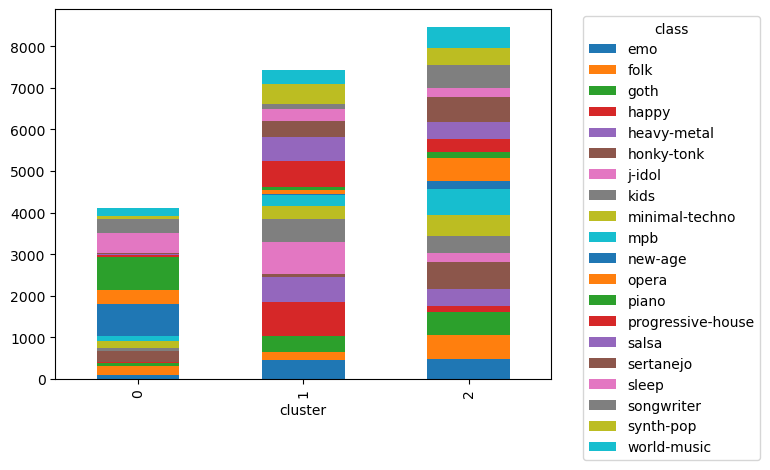

In [29]:
ax = pd.crosstab(df["cluster"], y2).plot(kind="bar", stacked=True)
plt.legend(title="class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [31]:
silhouette_average = silhouette_score(X_normalized, cluster_labels) 
silhouette_average

0.2811277024996547

In [82]:
#Uploading the tracks_df
df_tracks = pd.read_csv(r"/df_tracks_completed.csv")

In [33]:
df_filtered = df.iloc[::2]
df_filtered.reset_index(drop=True, inplace= True)   
# Adding the ids to the filtered version of the df
df_filtered['id'] = ids

C:\Users\marco\AppData\Local\Temp\ipykernel_6312\420139513.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['id'] = ids


In [34]:
merged_df2 = df_tracks.merge(df_filtered[['id', 'cluster']], on='id',how='left')

In [35]:
cleaned_df2 = merged_df2.dropna(subset=['cluster'])
cleaned_df2['cluster'] = cleaned_df2['cluster'].astype(int)

# Create a dictionary to map 'id' to 'genre'
id_to_genre = dict(zip(df_filtered['id'], y))

# Update 'genre' in cleaned_df2 based on 'id' if 'id' is not NaN
cleaned_df2['genre'] = cleaned_df2['id'].map(id_to_genre)

# Drop rows where 'id' is NaN
cleaned_df2.dropna(subset=['id'], inplace=True)

# Reset the index after dropping rows
cleaned_df2.reset_index(drop=True, inplace=True)

C:\Users\marco\AppData\Local\Temp\ipykernel_6312\1137153221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df2['cluster'] = cleaned_df2['cluster'].astype(int)
C:\Users\marco\AppData\Local\Temp\ipykernel_6312\1137153221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df2['genre'] = cleaned_df2['id'].map(id_to_genre)
C:\Users\marco\AppData\Local\Temp\ipykernel_6312\1137153221.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

In [45]:
cleaned_df2.loc[cleaned_df2['cluster'] == 1, 'cluster'] = 3

In [46]:
cleaned_df2.loc[cleaned_df2['cluster'] == 0, 'cluster'] = 1

In [47]:
cleaned_df2.loc[cleaned_df2['cluster'] == 3, 'cluster'] = 0

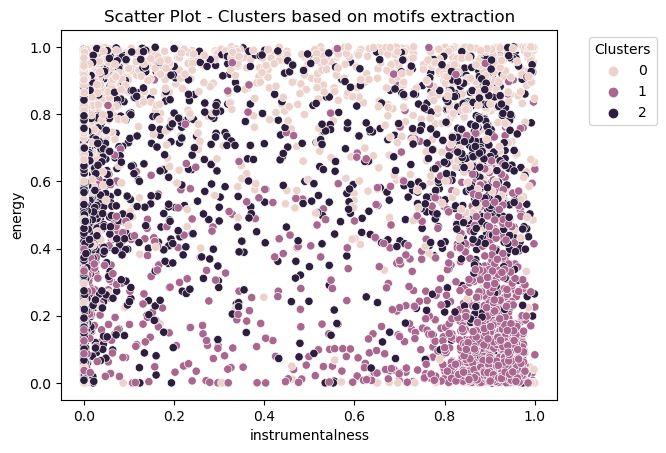

In [48]:
# Scatter plot - Euclidean 
sns.scatterplot(data=cleaned_df2, x='instrumentalness', y='energy', hue='cluster')
plt.title('Scatter Plot - Clusters based on motifs extraction')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

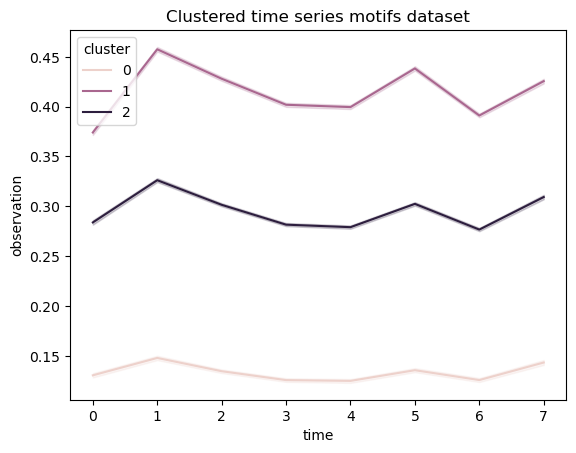

In [55]:
df_normalized['cluster'] = cluster_labels
df_melt = df_normalized.melt(value_name="observation", var_name="time", id_vars="cluster")
sns.lineplot(data=df_melt, x="time", y="observation", hue="cluster")
plt.title("Clustered time series motifs dataset")
plt.show()

In [78]:
for i in range(2):
    cluster = cleaned_df2[cleaned_df2['cluster'] == i].groupby(['cluster', 'genre']).size()
    print(cluster.sort_values(ascending=False))

cluster  genre            
0        happy                415
         j-idol               393
         progressive-house    312
         heavy-metal          303
         salsa                291
         kids                 256
         synth-pop            247
         emo                  220
         sertanejo            198
         goth                 185
         minimal-techno       160
         world-music          157
         sleep                149
         mpb                  131
         folk                  81
         songwriter            73
         opera                 69
         honky-tonk            42
         piano                 35
         new-age               11
dtype: int64
cluster  genre            
1        piano                416
         new-age              358
         sleep                255
         songwriter           181
         opera                164
         honky-tonk           133
         folk                  92
         minima

## Decision Tree across the clusters
***

In [ ]:
X = cleaned_df2[['instrumentalness', 'energy']] # Features
y3 = cleaned_df2['cluster']  # Target variable

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y3, test_size=0.05, random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [42]}

# Create the decision tree classifier
clf = DecisionTreeClassifier()
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=100, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Perform the random search
random_search.fit(X_train, y_train)

# Get the best model and evaluate
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Best Parameters:", random_search.best_params_)
print("Best Model Accuracy:", accuracy)

In [ ]:
X_df = pd.DataFrame(X_scaled)

In [ ]:
# Train the model on the training data
clf = DecisionTreeClassifier(random_state= 42, min_samples_split=6, min_samples_leaf=4, max_features=None, max_depth=4, criterion= 'gini')
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
def plot_decision_boundary(clf, X, y, feature1, feature2):
    # Fit the classifier
    clf.fit(X[[feature1, feature2]], y)

    # Create a meshgrid from 0 to 1
    xx, yy = np.meshgrid(np.linspace(0, 1, 100),
                         np.linspace(0, 1, 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[feature1], X[feature2], c=y, marker='o', edgecolor='k')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title("Decision Boundary")
    plt.show()

# Call the function for two features
plot_decision_boundary(clf, X, y3, 'instrumentalness', 'energy')

In [ ]:
def plot_decision_boundary(clf, X, y, feature1, feature2):
    # Fit the classifier
    clf.fit(X[[feature1, feature2]], y)

    # Create a meshgrid from 0 to 1
    xx, yy = np.meshgrid(np.linspace(0, 1, 100),
                         np.linspace(0, 1, 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[feature1], X[feature2], c=y, marker='o', edgecolor='k')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title("Decision Boundary")
    plt.show()

# Call the function for two features
plot_decision_boundary(clf, X_df, y3, np.array(0), np.array(1))

## Clustering considering other features of the df_tracks

In [ ]:
# Define the specific numerical attributes
numerical_attributes = ['popularity', 'danceability', 'energy', 'instrumentalness']

# Generate combinations of numerical attributes (pairs)
attribute_combinations = list(itertools.combinations(numerical_attributes, 2))

# Iterate over each pair of numerical attributes
for attr1, attr2 in attribute_combinations:
    # Scatter plot - Euclidean Clusters
    sns.scatterplot(data=cleaned_df2, x=attr1, y=attr2, hue='cluster')
    plt.title(f'Scatter Plot - Clusters ({attr1} vs {attr2})')
    plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## Anomaly Discovery

In [73]:
anoms = discords(mp, ex_zone=3, k=5)
anoms

array([242,  24, 245,  94,  46])

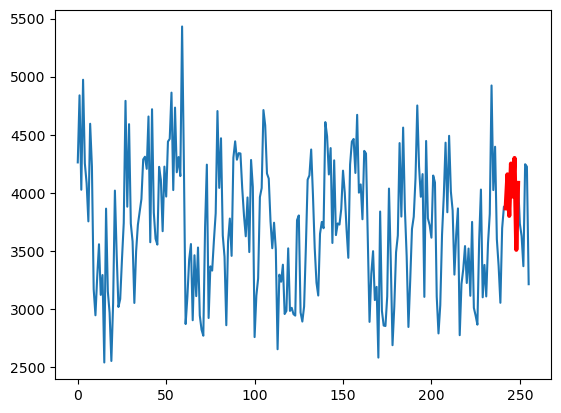

In [74]:
plt.plot(X_paa[0][0])
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = X_paa[0][0][a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()


## Features-based Clustering

In [7]:
import scipy.stats as stats

In [7]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        #'std': np.std(values),
        #'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        #'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        #'skw': stats.skew(values),
        #'kur': stats.kurtosis(values)
    }
    return features

In [8]:
X_paa_df= pd.DataFrame(np.squeeze(X_paa))

In [9]:
X_paa_values = X_paa_df.values
X_paa_values
# Defining the scaler
scaler = MinMaxScaler()
# Fit and transform the data
X_paa_norm = scaler.fit_transform(X_paa_values)

In [10]:
feature_values = [list(calculate_features(row).values()) for row in X_paa_norm[:,:]]
index_values = list(range(0, X_paa_norm.shape[0]))
column_values = list(calculate_features(X_paa_norm[0][0]).keys())

X_features_df= pd.DataFrame(data = feature_values, index = index_values, columns = column_values) 

In [11]:
X_scaled= X_features_df.values

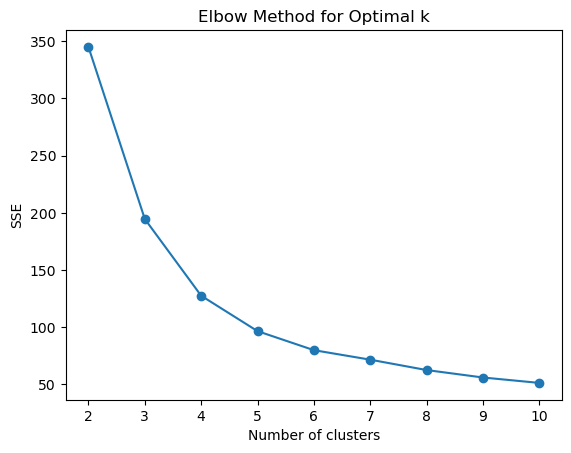

In [12]:
sse_list = []
for k in range(2, 11):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse_list.append(kmeans.inertia_)

# 3. Plot the SSE scores to select the optimal number of clusters (optional)
import matplotlib.pyplot as plt

plt.plot(range(2, 11), sse_list, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

In [13]:
optimal_k = 3 # Choose the optimal number of clusters based on the elbow plot or other criteria
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)

# 6. Evaluate the clustering using silhouette score (optional)
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# 7. Access cluster centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

Silhouette Score: 0.46582811040485184


In [14]:
X_features_df['cluster'] = labels

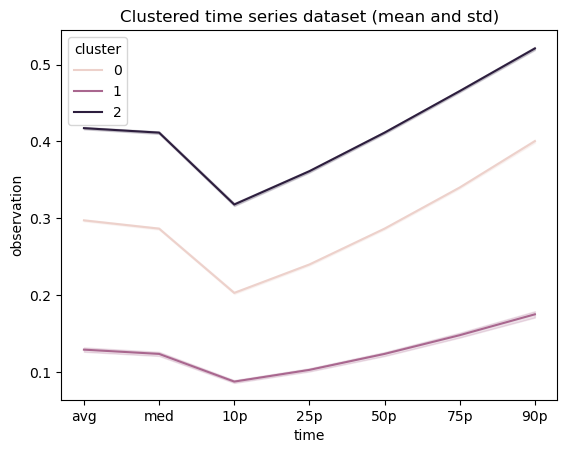

In [97]:
df_melt = X_features_df.melt(value_name="observation", var_name="time", id_vars="cluster")
sns.lineplot(data=df_melt, x="time", y="observation", hue="cluster")
plt.title("Clustered time series dataset (mean and std)")
plt.show()

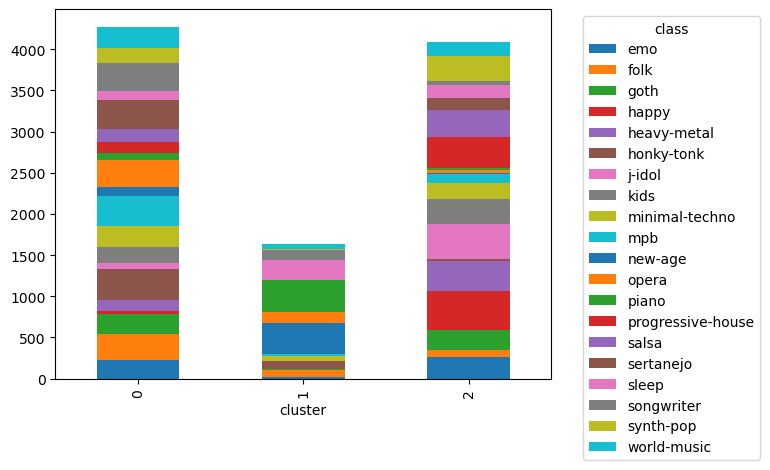

In [15]:
ax = pd.crosstab(X_features_df["cluster"], y).plot(kind="bar", stacked=True)
plt.legend(title="class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#Not very insightful...

In [17]:
X_features_df['genre'] = y

In [19]:
for i in range(3):
    cluster = X_features_df[X_features_df['cluster'] == i].groupby(['cluster', 'genre']).size()
    print(cluster)

cluster  genre            
0        emo                  227
         folk                 315
         goth                 245
         happy                 32
         heavy-metal          134
         honky-tonk           378
         j-idol                75
         kids                 196
         minimal-techno       250
         mpb                  366
         new-age              115
         opera                325
         piano                 86
         progressive-house    124
         salsa                169
         sertanejo            352
         sleep                105
         songwriter           338
         synth-pop            184
         world-music          258
dtype: int64
cluster  genre            
1        emo                   15
         folk                  90
         goth                  17
         honky-tonk            93
         kids                   5
         minimal-techno        55
         mpb                   22
         new-ag

In [9]:
dic_0 = {'happy':'468 (+0)', 'j-idol': '425 (-6)', 
         'progressive-house': '375 (-3)', 'heavy-metal': '366 (-9)', 'salsa': '326 (-9)', 'synth-pop': '303 (-6)',
        'kids': '298 (-14)'}

dic_1 = {'piano':'383 (+0)', 'new-age':'376 (+7)', 'sleep':'244 (+2)', 'opera': '138 (+19)', 'songwriter': '112 (+5)', 
         'honky-tonk': '378 (+20)', 'folk':'90 (+9)'}

In [33]:
red = '\033[31m'
reset = '\033[0m'
green = '\033[32m'


print('Cluster 0\n')
print('{}: '.format(list(dic_0.keys())[0]) + green + dic_0[list(dic_0.keys())[0]] + reset)

for key, value in list(dic_0.items())[1:]:
    print('{}:'.format(key), end = ' ')
    print(red + value + reset)


Cluster 0

happy: 468 (+0)
j-idol: 425 (-6)
progressive-house: 375 (-3)
heavy-metal: 366 (-9)
salsa: 326 (-9)
synth-pop: 303 (-6)
kids: 298 (-14)


In [35]:
print('Cluster 1\n')

green = '\033[32m'
reset = '\033[0m'

for key, value in dic_1.items():
    print('{}: '.format(key) + green +  value + reset)

Cluster 1

piano: 383 (+0)
new-age: 376 (+7)
sleep: 244 (+2)
opera: 138 (+19)
songwriter: 112 (+5)
honky-tonk: 378 (+20)
folk: 90 (+9)


In [124]:
X_paa_df = pd.DataFrame(np.squeeze(X_paa))
X_paa_df['id'] = ids
X_paa_df['cluster'] = labels

In [125]:
merged_df1 = df_tracks.merge(X_paa_df[['id', 'cluster']], on='id',how='left')

In [126]:
cleaned_df = merged_df1.dropna(subset=['cluster'])
cleaned_df.loc[:, 'cluster'] = cleaned_df['cluster'].astype(int)

In [128]:
cleaned_df['cluster'] = cleaned_df['cluster'].astype(int)
cleaned_df

C:\Users\marco\AppData\Local\Temp\ipykernel_23900\222547110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['cluster'] = cleaned_df['cluster'].astype(int)


id                             name  duration_ms  \
5      7E7POHU96XKXbiubARcPBD                       Time Again       501737   
7      7kyiQ2oxgT0XX8yhzBWE6t                          Cloches       419047   
8      6c6Zt0g2m2s4yLxnK1NazG                        Conscious       455040   
10     2qQusCcWR2A9Q6lK5Uz6bw         Evolution - Original Mix       382500   
11     3CPEi77tTjJDlUgZKXpoOl                   Happiness Lies       524159   
...                       ...                              ...          ...   
79728  1FLhGUcHcWs8usJNi3yJ0c                         Dat Dere       321150   
79729  7ny1jOJSZAF6VBb7x9DRO2                            Fired       229506   
79730  4aaOblwrIiVnScKL51pGdo  You're Only Human (Second Wind)       288440   
79732  4SQx6YAAwKYT36xt4hol6G                   Kisse the Girl       184005   
79736  4VA8Z5k2hd4RkBTlJFPPyd                     Baby Lullaby       188000   

       explicit  popularity  \
5             0          47   
7             0          47   
8             0          39   
10            0          42   
11            0          31   
...         ...         ...   
79728         0          27   
79729         0          30   
79730         0          51   
79732         0          29   
79736         0          30   

                                                 artists   album_type  \
5                            Jan Blomqvist;Alar;Korolova       single   
7                                                Worakls        album   
8                                               Ann Clue       single   
10                                      UMEK;Cosmic Boys       single   
11                                         Boris Brejcha       single   
...                                                  ...          ...   
79728                                      Bobby Timmons        album   
79729                                          Ben Folds        album   
79730                                         Billy Joel  compilation   
79732  Michael Hanley;Disney Peaceful Piano;Disney Pe...       single   
79736                                        Piano Peace        album   

                               album_name album_release_date  \
5                              Time Again         2021-04-16   
7                               Orchestra         2019-03-08   
8                   Rumbling Conversation         2015-12-22   
10        Evolution / Feels Like a Tunnel         2020-03-27   
11                                   FEAR         2016-09-13   
...                                   ...                ...   
79728          This Here Is Bobby Timmons               1960   
79729                 Rockin' The Suburbs         2001-09-11   
79730  Greatest Hits Volume I & Volume II         1985-06-29   
79732   Acoustic Disney Music to Relax to         2020-11-28   
79736      Baby Lullaby Piano Sleep Music         2017-03-10   

       album_total_tracks  ...  n_beats           genre  fade_out_duration  \
5                       1  ...   1025.0  minimal-techno               4482   
7                      10  ...    870.0  minimal-techno              12814   
8                       2  ...    944.0  minimal-techno               4684   
10                      2  ...    777.0  minimal-techno              19323   
11                      3  ...   1091.0  minimal-techno              26080   
...                   ...  ...      ...             ...                ...   
79728                   9  ...    397.0           piano               4297   
79729                  12  ...    601.0           piano               8348   
79730                  25  ...    622.0           piano              12791   
79732                   5  ...    350.0           piano               8184   
79736                  40  ...    314.0           piano              12324   

            primary_artist_id  \
5      5wMlMjOLeJfS5DfxqGfm83   
7      5RPzPJCg4ER1LzQkorZ31p   
8      5fasubnSIOTRYlIZ

In [129]:
# Create a copy of the dataframe
cleaned_df = cleaned_df.copy()
# Rename 'cluster' and 'cluster_label' columns
cleaned_df.rename(columns={'cluster': 'euclidean_cluster_labels'}, inplace=True)

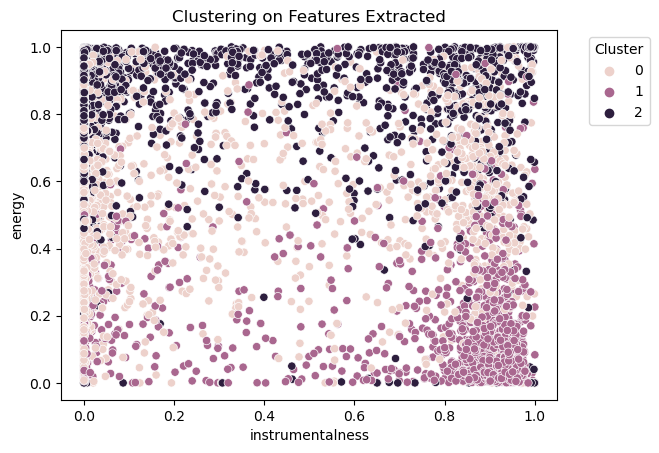

In [130]:
# Scatter plot - Euclidean Clusters
sns.scatterplot(data=cleaned_df, x='instrumentalness', y='energy', hue='euclidean_cluster_labels')
plt.title('Clustering on Features Extracted')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

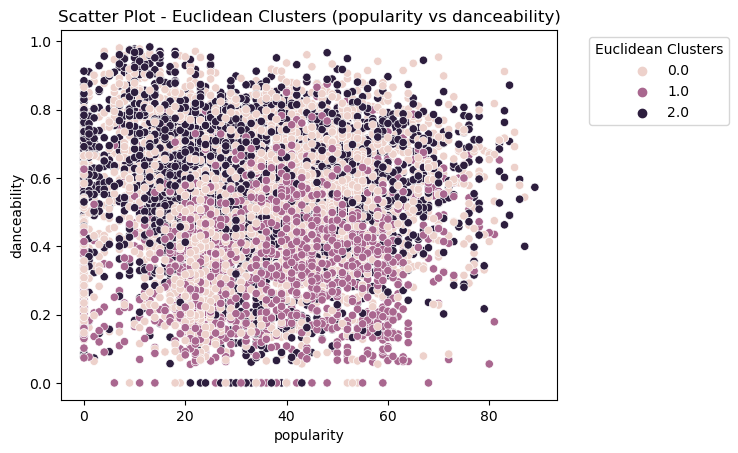

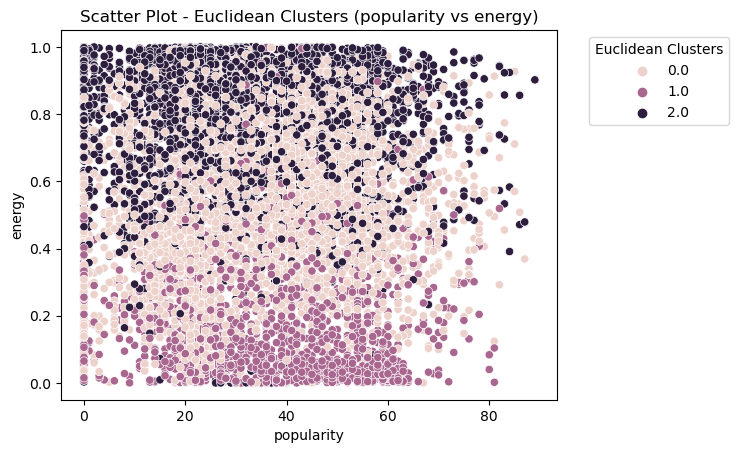

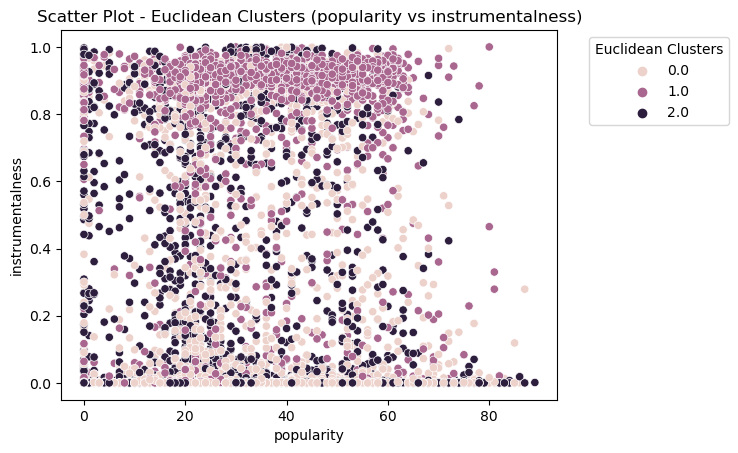

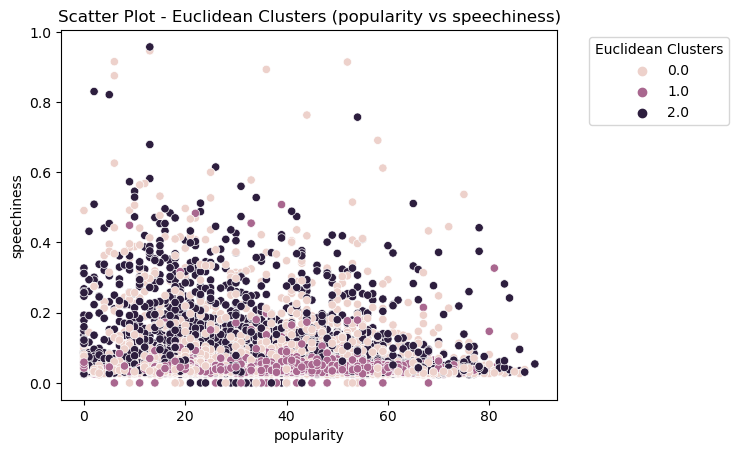

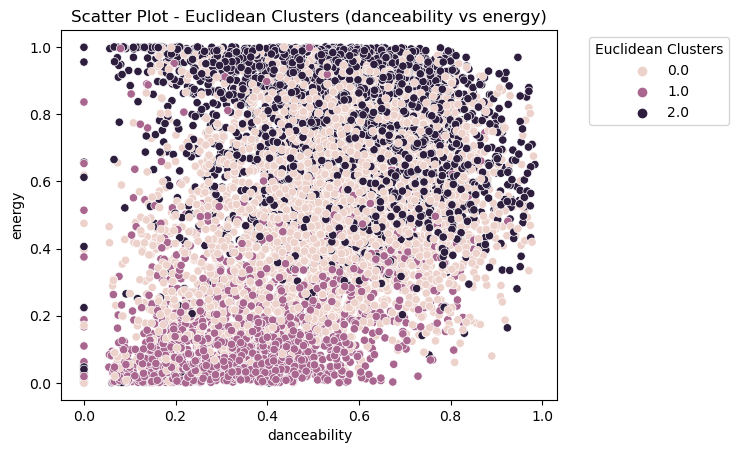

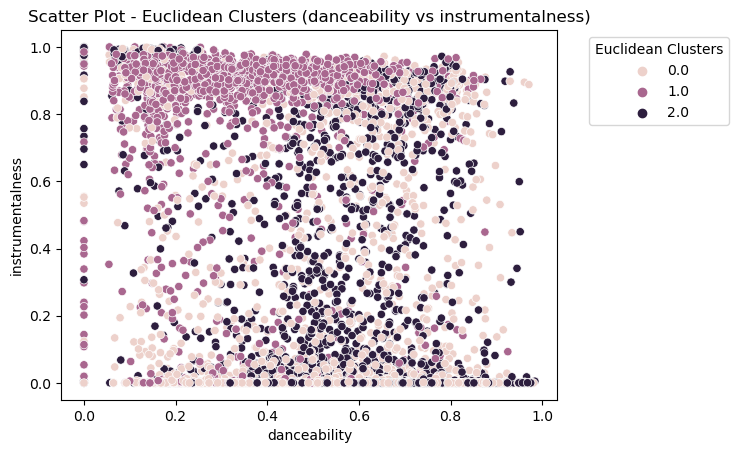

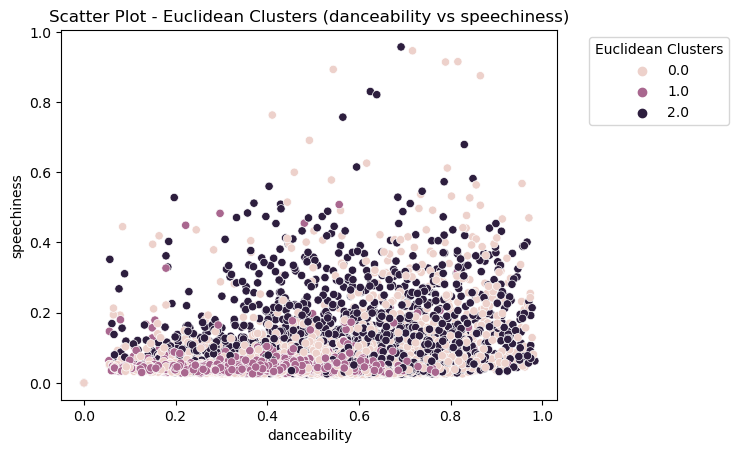

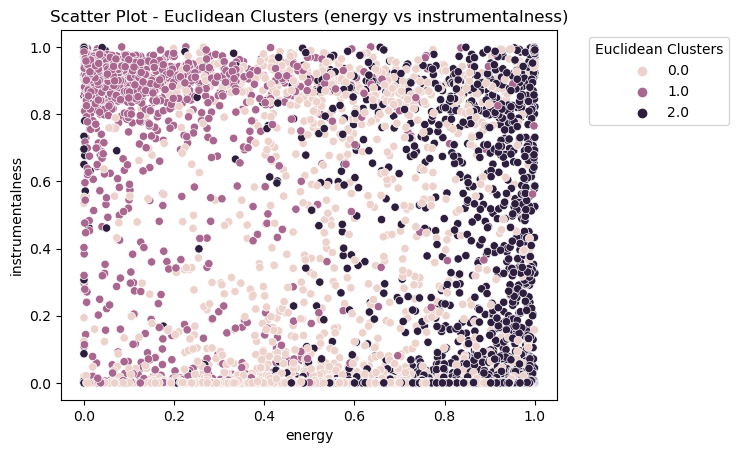

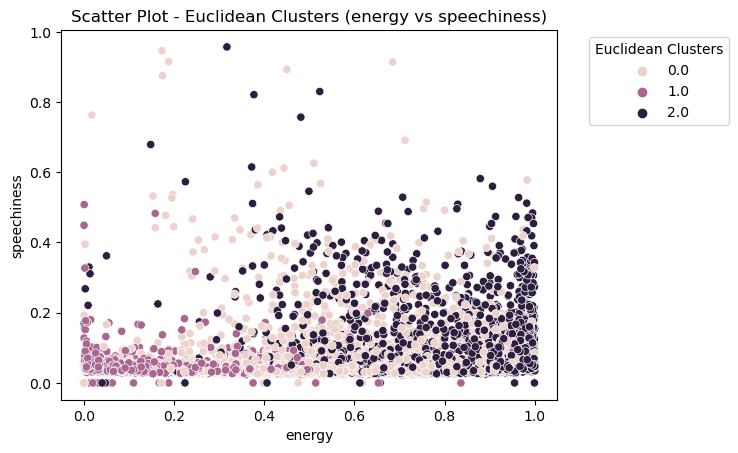

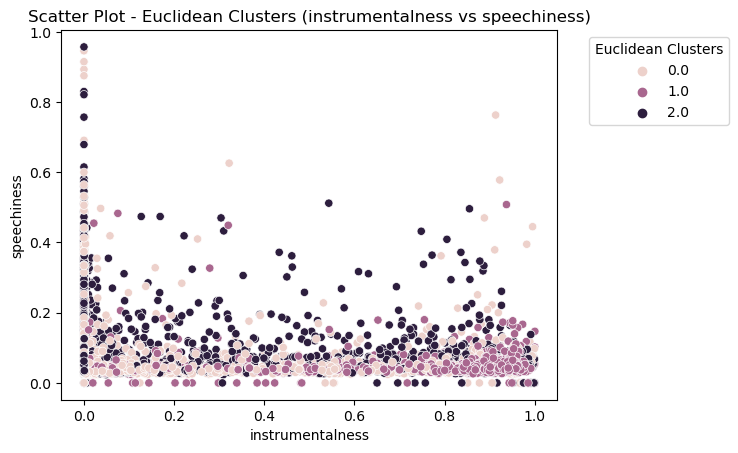

In [44]:
# Define the specific numerical attributes
numerical_attributes = ['popularity', 'danceability', 'energy', 'instrumentalness', 'speechiness']

# Generate combinations of numerical attributes (pairs)
attribute_combinations = list(itertools.combinations(numerical_attributes, 2))

# Iterate over each pair of numerical attributes
for attr1, attr2 in attribute_combinations:
    # Scatter plot - Euclidean Clusters
    sns.scatterplot(data=cleaned_df, x=attr1, y=attr2, hue='euclidean_cluster_labels')
    plt.title(f'Scatter Plot - Euclidean Clusters ({attr1} vs {attr2})')
    plt.legend(title='Euclidean Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## Classification
***

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold
from sktime.classification.kernel_based import RocketClassifier
#from aeon.classification.convolution_based import RocketClassifier

In [34]:
from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Shapelets

In [35]:
# Splitting data into training (9000) and testing (1000)
X_train, X_test, y_train, y_test = train_test_split(X_paa, y, test_size=.0999, random_state=42)

In [327]:
# Create an array of original indices
original_indices = np.arange(len(X_paa))

# Split the original indices into train and test indices
original_train_indices, original_test_indices = train_test_split(original_indices, test_size=0.0999, random_state=42)

# Retrieve the original indices corresponding to X_train
X_train_original_indices = original_train_indices

# Display the original indices of X_train
print("Original Indices of X_train:", X_train_original_indices)

Original Indices of X_train: [7113 8157 6209 ... 5390  860 7270]


In [329]:
X_train_elements = X_paa[X_train_original_indices]

In [332]:
# Create an array of original indices
original_indices = np.arange(len(X_paa))

# Split the original indices into train and test indices
original_train_indices, original_test_indices = train_test_split(original_indices, test_size=0.0999, random_state=42)

# Retrieve the original indices corresponding to X_train
X_test_original_indices = original_test_indices

# Display the original indices of X_train
X_test_elements = X_paa[X_test_original_indices]
X_test_elements.shape

(999, 1, 256)

In [221]:
X_train_xpaa = pd.DataFrame(np.squeeze(X_train))

In [324]:
X_train.shape

(9000, 1, 256)

In [36]:
scaler = TabularToSeriesAdaptor(StandardScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
rst = RandomShapeletTransform(n_shapelet_samples=1000, max_shapelets=100, min_shapelet_length=8, max_shapelet_length=None, n_jobs=-1) #n_jobs -1 uses all processors

In [39]:
rst.fit(X_train_scaled, y_train)

RandomShapeletTransform(max_shapelets=100, min_shapelet_length=8, n_jobs=-1,
                        n_shapelet_samples=1000)

In [54]:
shapelets = rst.shapelets

In [44]:
df_shapelets = pd.DataFrame(shapelets)

In [47]:
df_shapelets.to_csv('df_shapelets.csv', index=False)

In [48]:
shapelets_distances_train = rst.transform(X_train_scaled)
shapelets_distances_test = rst.transform(X_test_scaled)

In [325]:
len(shapelets_distances_train)

9000

In [75]:
# Define the classifier
clf = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 11),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 6),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [42]
}

# Perform grid search with cross-validation
grid_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=42)
grid_search.fit(shapelets_distances_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)


C:\Users\marco\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
100 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\marco\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\marco\anaconda\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\marco\anaconda\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\marco\anaconda\Lib\site-packages\skl

Best parameters: {'random_state': 42, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}


In [76]:
clf = DecisionTreeClassifier(random_state=42, min_samples_split=4, min_samples_leaf=5, max_features=None, max_depth=10, criterion='gini')
clf = clf.fit(shapelets_distances_train, y_train)
y_pred = clf.predict(shapelets_distances_test)
print(classification_report(y_test, y_pred))
# Acc: with Random Search .16; without .14

                   precision    recall  f1-score   support

              emo       0.11      0.09      0.10        46
             folk       0.06      0.04      0.04        57
             goth       0.00      0.00      0.00        44
            happy       0.48      0.41      0.44        59
      heavy-metal       0.07      0.07      0.07        41
       honky-tonk       0.11      0.09      0.10        45
           j-idol       0.07      0.24      0.11        46
             kids       0.19      0.18      0.19        55
   minimal-techno       0.56      0.53      0.54        53
              mpb       0.00      0.00      0.00        49
          new-age       0.26      0.35      0.30        54
            opera       0.17      0.20      0.18        40
            piano       0.10      0.08      0.09        49
progressive-house       0.38      0.28      0.32        47
            salsa       0.08      0.09      0.09        55
        sertanejo       0.08      0.25      0.12       

In [360]:
clf = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 11),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 6),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [42]
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train_sm, y_train)

# Print the best parameters found
print("Best parameters:", random_search.best_params_)

C:\Users\marco\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
100 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\marco\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\marco\anaconda\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\marco\anaconda\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\marco\anaconda\Lib\site-packages\skl

Best parameters: {'random_state': 42, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 9, 'criterion': 'gini'}


In [361]:
clf = DecisionTreeClassifier(random_state=42, min_samples_split=10, min_samples_leaf=3, max_features=None, max_depth=9, criterion='gini')
clf = clf.fit(X_train_sm, y_train)
y_pred = clf.predict(X_test_sm)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.20      0.04      0.07        46
             folk       0.12      0.04      0.05        57
             goth       0.00      0.00      0.00        44
            happy       0.60      0.51      0.55        59
      heavy-metal       0.19      0.32      0.23        41
       honky-tonk       0.20      0.56      0.30        45
           j-idol       0.26      0.24      0.25        46
             kids       0.24      0.18      0.21        55
   minimal-techno       0.64      0.40      0.49        53
              mpb       0.12      0.18      0.15        49
          new-age       0.42      0.52      0.46        54
            opera       0.44      0.28      0.34        40
            piano       0.58      0.39      0.46        49
progressive-house       0.19      0.15      0.17        47
            salsa       0.17      0.38      0.23        55
        sertanejo       0.13      0.39      0.19       

In [349]:
shapelets_and_motifs_train = pd.concat([shapelets_distances_train, min_distances_df_train], axis=1, ignore_index=True)

new_column_names = [f'{i + len(shapelets_distances_train.columns)}' for i in range(len(min_distances_df_train.columns))]

# Assign the new column names to the result DataFrame
shapelets_and_motifs_train.columns = list(shapelets_distances_train.columns) + new_column_names

# Display the result
shapelets_and_motifs_train

0         1         2         3         4         5         6  \
0     1.248227  1.427432  1.478157  1.455247  1.557467  1.569142  1.210657   
1     0.911316  1.436541  1.572778  1.417466  1.463049  1.438786  0.901120   
2     1.143759  1.472146  1.550651  1.524128  1.562158  1.619083  1.086888   
3     1.052498  0.987259  1.324869  1.143552  1.235275  1.309853  0.862440   
4     1.253060  1.724647  1.640992  1.538894  1.676247  1.530338  1.145188   
...        ...       ...       ...       ...       ...       ...       ...   
8995  1.349567  1.281650  1.550055  1.300421  1.560365  1.533351  1.174173   
8996  0.973629  1.249180  1.164198  1.144248  1.235341  1.293498  1.173389   
8997  1.056280  1.086414  1.433467  1.442549  1.354552  1.334835  0.846197   
8998  1.220403  1.649080  1.566725  1.537591  1.456591  1.636095  0.864416   
8999  1.202288  1.382266  1.116161  1.224689  1.465178  1.661401  1.230500   

             7         8         9  ...       110       111       112  \
0     0.692097  1.314955  1.021121  ...  2.486122  0.802481  2.831364   
1     0.607546  1.278786  0.897040  ...  3.657710  0.548883  3.182888   
2     0.671135  1.389060  0.815287  ...  5.484046  2.386762  6.134686   
3     0.615731  1.434161  0.875529  ...  2.573273  1.550603  0.657594   
4     0.628036  1.315872  0.815987  ...  2.918538  0.164663  1.288489   
...        ...       ...       ...  ...       ...       ...       ...   
8995  0.701304  1.450910  1.168981  ...  2.601125  0.559292  0.848205   
8996  0.899014  1.438840  1.026066  ...  2.689539  0.687968  1.392148   
8997  0.366036  1.426010  1.038558  ...  2.809589  3.019718  0.763683   
8998  0.764360  1.500803  1.114420  ...  3.389909  0.424993  3.146398   
8999  0.926967  1.610589  1.071751  ...  2.549830  2.831027  0.858757   

           113       114       115       116       117       118       119  
0     2.194122  2.782664  1.381467  2.769165  1.194072  0.524996  0.964427  
1     2.756490  3.582139  1.355155  3.430757  1.348973  1.381877  3.029012  
2     5.610484  6.442084  3.741298  6.298667  4.195102  1.187403  0.269636  
3     0.668851  0.587304  1.120612  0.818495  0.813157  2.715575  4.363330  
4     1.177771  1.505259  0.855988  1.046386  0.418037  0.377702  1.677403  
...        ...       ...       ...       ...       ...       ...       ...  
8995  1.184389  1.391964  0.821972  1.227881  0.616282  1.201883  2.691304  
8996  0.740098  1.686953  1.005848  1.654404  0.637351  1.020048  2.204964  
8997  0.484025  1.117244  1.866564  1.256319  1.451627  4.099260  5.639268  
8998  2.630596  3.509139  1.080924  3.326383  1.181756  0.230641  0.775769  
8999  0.668362  0.860809  1.454494  0.953697  1.064177  3.991207  5.541594  

[9000 rows x 120 columns]

In [350]:
X_train_sm = shapelets_and_motifs_train.values

In [356]:
shapelets_and_motifs_test = pd.concat([shapelets_distances_test, min_distances_df_test], axis=1, ignore_index=True)

new_column_names = [f'{i + len(shapelets_distances_test.columns)}' for i in range(len(min_distances_df_test.columns))]

# Assign the new column names to the result DataFrame
shapelets_and_motifs_test.columns = list(shapelets_distances_test.columns) + new_column_names

# Display the result
shapelets_and_motifs_test

0         1         2         3         4         5         6  \
0    1.402235  0.647932  1.059708  0.457841  1.078216  1.505659  1.279169   
1    1.114514  1.474176  1.466518  1.523195  1.544400  1.621022  0.824125   
2    1.283179  1.379655  1.333344  1.272750  1.493672  1.571028  1.063265   
3    0.995950  1.369155  1.649198  1.471996  1.479751  1.537030  1.147082   
4    1.282104  1.479400  1.657195  1.609028  1.585844  1.512523  1.117536   
..        ...       ...       ...       ...       ...       ...       ...   
994  1.039176  1.206121  1.540707  1.306132  1.419703  1.610668  0.722436   
995  1.069417  1.383323  1.468631  1.367234  1.535271  1.275320  1.016452   
996  0.631820  1.388566  1.558898  1.550228  1.584963  1.440083  0.609557   
997  0.375722  1.387798  1.483487  1.391185  1.607053  1.357572  1.064447   
998  0.747780  1.464376  1.543932  1.451768  1.474668  1.510440  0.532070   

            7         8         9  ...       110       111       112  \
0    0.835403  1.316223  1.194598  ...  2.102034  0.967448  0.693362   
1    0.539490  1.398898  1.144958  ...  2.539117  0.350863  2.095328   
2    0.865520  1.525199  0.915207  ...  2.526607  0.809635  1.749816   
3    0.697443  1.221663  1.066578  ...  2.717569  2.174412  0.621461   
4    0.730032  1.410543  1.129590  ...  3.404800  0.711250  3.142836   
..        ...       ...       ...  ...       ...       ...       ...   
994  0.198768  1.334380  0.802977  ...  2.715068  3.138711  0.465426   
995  0.653122  1.340907  0.981527  ...  2.434374  0.376367  1.191884   
996  0.379585  1.006843  1.043326  ...  2.950021  2.977839  0.716449   
997  0.497600  1.471135  0.567912  ...  3.317504  3.246021  0.671814   
998  0.243239  1.388198  0.944690  ...  3.216239  0.446211  3.139459   

          113       114       115       116       117       118       119  
0    1.181179  1.254286  0.850751  1.200955  0.754266  1.737582  3.264077  
1    1.330364  1.928954  0.650738  2.356822  0.730985  0.852873  2.310955  
2    1.383499  1.585490  0.600670  1.835443  0.608558  1.196739  2.438609  
3    0.728978  1.091703  1.423238  0.946266  0.668095  3.298756  4.965158  
4    2.760500  3.544169  1.341111  3.333689  1.497231  0.320722  0.780974  
..        ...       ...       ...       ...       ...       ...       ...  
994  0.842161  1.056477  2.188224  1.157454  1.478761  4.345339  5.986746  
995  0.969037  1.378857  0.937985  1.417398  0.738907  0.856125  2.060061  
996  0.851901  1.110156  1.801782  1.102492  1.543078  4.167982  5.823672  
997  1.092168  1.323357  2.230502  0.984850  1.537248  4.447430  6.099995  
998  2.418848  3.215593  1.090884  3.380515  1.565508  0.360395  1.523692  

[999 rows x 120 columns]

In [357]:
X_test_sm = shapelets_and_motifs_test.values

### ROCKET: Advanced Classification through random convolutional kernels

In [ ]:
## First, 3-class Classification

X_train = np.array(X_train)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize RocketClassifier with desired parameters
rocket = RocketClassifier(rocket_transform="minirocket", n_jobs=-1)

# Initialize an empty list to store the classification reports
classification_reports = []

# Perform cross-validation
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
    
    # Fit the classifier on the training fold
    rocket.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the test fold
    y_pred_fold = rocket.predict(X_test_fold)
    
    # Generate and append classification report to the list
    classification_reports.append(classification_report(y_test_fold, y_pred_fold))

# Print the classification reports for each fold
for fold_idx, report in enumerate(classification_reports):
    print(f"Classification Report for Fold {fold_idx + 1}:")
    print(report)


In [ ]:
# Assuming X_train and y_train are already defined

X_train = np.array(X_train)
X_test = np.array(X_test)

# Initialize RocketClassifier with desired parameters
rocket = RocketClassifier(rocket_transform="minirocket", n_jobs=-1)

# Train the classifier on the entire training set
rocket.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = rocket.predict(X_test)

# Print the classification report for the test set
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred_test))


In [ ]:
### Now let's predict the 20 genres

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(np.squeeze(X_train))
X_test_normalized = scaler.transform(np.squeeze(X_test))

In [13]:
# Step 3: Further split the training set into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_normalized, y_train, test_size=0.2, random_state=42)
# Step 4: Apply ROCKET classifier with 5-fold cross-validation on X_train_final and y_train_final
rocket = RocketClassifier(rocket_transform="minirocket", n_jobs=-1)

In [ ]:
# Cross-validation
cv_scores = cross_val_score(rocket, X_train_final, y_train_final, cv=3)
# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

In [15]:
# Step 5: Train the model on the entire training set (X_train_normalized, y_train)
rocket.fit(X_train_normalized, y_train)
# Predict labels for the test set
y_pred = rocket.predict(X_test_normalized)
# Compute and print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                   precision    recall  f1-score   support

              emo       0.42      0.30      0.35        46
             folk       0.16      0.09      0.11        57
             goth       0.10      0.05      0.06        44
            happy       0.68      0.69      0.69        59
      heavy-metal       0.38      0.56      0.46        41
       honky-tonk       0.39      0.60      0.47        45
           j-idol       0.35      0.39      0.37        46
             kids       0.45      0.47      0.46        55
   minimal-techno       0.73      0.70      0.71        53
              mpb       0.15      0.08      0.11        49
          new-age       0.51      0.57      0.54        54
            opera       0.40      0.57      0.47        40
            piano       0.67      0.53      0.59        49
progressive-house       0.41      0.60      0.48        47
            salsa       0.38      0.51      0.44        55
        sertanejo       0.22    

In [84]:
df_tracks.columns

Index(['id', 'name', 'duration_ms', 'explicit', 'popularity', 'artists',
       'album_type', 'album_name', 'album_release_date', 'album_total_tracks',
       'danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness',
       'valence', 'time_signature', 'n_beats', 'genre', 'fade_out_duration',
       'primary_artist_id', 'other_artists_id', 'primary_artist_popularity',
       'other_artists_popularity', 'average_artists_popularity',
       'sum_of_followers'],
      dtype='object')